Begun 2/8/25

Same as array_diff_larger_set_w2_and_w2w4_higherell_largerbins_20250207.ipynb with the corrected code and ell of 1000-3000, but this one uses bins of 200 instead of 400 to see if that is better.

Results in angle_calc_1738974973

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm, font_manager
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import datetime
import healpy as hp
from scipy import optimize as op
from scipy import stats
import os
from scipy.stats.distributions import chi2
from itertools import combinations

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1738974973/angle_calc_1738974973_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'fsky', 'w2w4_depth1', 'w2w4_cross', 'w2w4_ref', 'meas_angle', 'meas_errbar', 'initial_timestamp', 'median_timestamp', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [7]:
# Implementing automatic data cuts
cut_flags = np.zeros(n_maps)
ivar_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
residual_sums = np.zeros(n_maps)
angles_rad = np.zeros(n_maps)
errbars_rad = np.zeros(n_maps)
for i in range(n_maps):
    cut_flags[i] = spectra_dict[maps[i]]['map_cut']
    all_errbars[i] = spectra_dict[maps[i]]['meas_errbar']
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    residual_sums[i] = spectra_dict[maps[i]]['residual_sum']
    angles_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_angle'])
    errbars_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_errbar'])

# Extracting map info and results into separate arrays for ease of access
# Not using numpy arrays at first to more easily put strings and arrays in the list
map_arrays = []
map_timestamps = []
estimators = []
covariances = []
all_e2xe2 = []

for i in range(n_maps):
    map_arrays.append(maps[i].split('_')[2])
    map_timestamps.append(maps[i].split('_')[1])
    estimators.append(spectra_dict[maps[i]]['estimator'])
    covariances.append(spectra_dict[maps[i]]['covariance'])
    all_e2xe2.append(spectra_dict[maps[i]]['E2xE2'])
map_arrays = np.array(map_arrays)
map_timestamps = np.array(map_timestamps)
estimators = np.array(estimators)
covariances = np.array(covariances)
all_e2xe2 = np.array(all_e2xe2)

# Doing cuts
ivar_cutoff = 4.0
residual_cutoff = 1700
    
print("Total number of maps: ", n_maps)
# Identifying maps that weren't cut by the galaxy mask
cut_good = np.where(cut_flags != 1)[0]
print("Maps passing galaxy mask cut: ", len(cut_good))
# Using the super small errorbars to identify the failed fits - there were none in this run
errbar_good = np.where(all_errbars>0.1)[0]
print("Maps passing bad fit cut: ", len(errbar_good))
# Using residual cutoff of 2000 - cuts come from analysis in data_quality_larger_set_corrected_mode_count_20241212.ipynb
residual_good = np.where(residual_sums<residual_cutoff)[0]
print("Maps passing residual cut: ", len(residual_good))
# Using ivar cutoff of 4.0
ivar_good = np.where(ivar_sums>ivar_cutoff)[0]
print("Maps passing ivar cut: ", len(ivar_good))
# Taking the intersection of these four sets to get those maps that pass all cuts
set_pass_all_cuts = np.intersect1d(np.intersect1d(np.intersect1d(cut_good,errbar_good),residual_good),ivar_good)
print("Maps passing all four cuts: ", len(set_pass_all_cuts))
print(set_pass_all_cuts)

Total number of maps:  264
Maps passing galaxy mask cut:  249
Maps passing bad fit cut:  244
Maps passing residual cut:  165
Maps passing ivar cut:  176
Maps passing all four cuts:  131
[  1   8  20  21  23  24  25  26  27  29  30  37  38  39  47  48  51  56
  57  58  59  60  63  64  66  68  69  70  71  72  73  75  76  78  79  80
  81  82  83  84  85  87  88  89  90  91  92  93  94  96  97  98  99 100
 105 113 114 115 116 117 119 120 121 122 123 128 129 130 131 132 134 136
 141 142 144 145 149 150 151 152 153 154 155 156 157 158 159 160 162 163
 173 174 175 176 177 179 180 181 182 183 185 186 187 189 190 193 195 196
 197 199 200 202 205 211 212 213 217 218 219 221 222 227 232 233 243 244
 245 247 250 251 259]


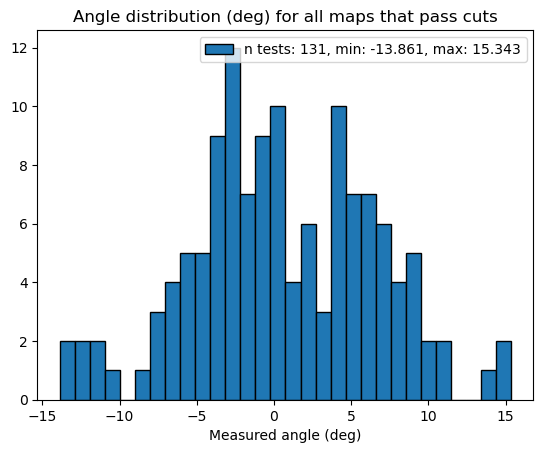

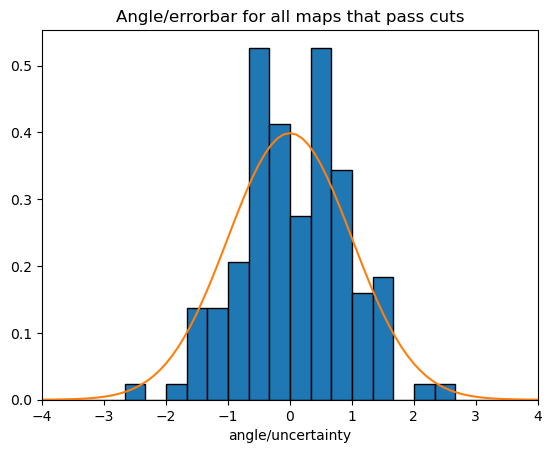

In [8]:
angles_deg = np.rad2deg(angles_rad)
errbars_deg = np.rad2deg(errbars_rad)
plt.hist(angles_deg[set_pass_all_cuts],bins=30, edgecolor='black',
        label=f'n tests: {len(set_pass_all_cuts)}, min: {np.min(angles_deg[set_pass_all_cuts]):.3f}, max: {np.max(angles_deg[set_pass_all_cuts]):.3f}')
plt.title("Angle distribution (deg) for all maps that pass cuts")
plt.xlabel("Measured angle (deg)")
plt.legend()
plt.show()
plt.close()

# The ratio angle/errbar should be normally distributed with std=1
x = np.arange(-4.0, 4.01, 0.1)
_, bins = np.histogram(x,bins=24)
n, _, _ = plt.hist(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts],bins=bins, edgecolor='black', density=True,
                     label=f'n tests: {len(set_pass_all_cuts)}, min: {np.min(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts]):.3f}, max: {np.max(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts]):.3f}')
plt.title("Angle/errorbar for all maps that pass cuts")
#x = np.arange(np.min(bins),np.max(bins),0.1)
x = np.arange(-4.0, 4.01, 0.1)
#print(bins)
# assuming normalized Gaussian of mean of zero and std=1
plt.plot(x, (1/np.sqrt(2*np.pi))*np.exp(-x**2/2),label='Gaussian mean=0 std=1')
#plt.legend()
plt.xlabel("angle/uncertainty")
plt.xlim(-4.0,4.0)
plt.show()
plt.close()

In [9]:
# Doing a Kolmogorov-Smirnov test to see how Gaussian the angle/uncertainty quantity is
# For a 95% confidence interval, the pvalue of the test should be greater than 0.05 if it is Gaussian
# All the standard defaults should work here.
results = stats.kstest(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts],
                       stats.norm.cdf)
print(results)
if results.pvalue > 0.05:
    print(f"Since {results.pvalue:.3f} > 0.05, we conclude that the distribution is consistent with a normal distribution at 95% confidence.")
else:
    print(f"Since {results.pvalue:.3f} < 0.05, we conclude that the distribution is NOT consistent with a normal distribution at 95% confidence.")

KstestResult(statistic=0.08471954854322716, pvalue=0.28748107452990623, statistic_location=-0.5733826103555912, statistic_sign=-1)
Since 0.287 > 0.05, we conclude that the distribution is consistent with a normal distribution at 95% confidence.


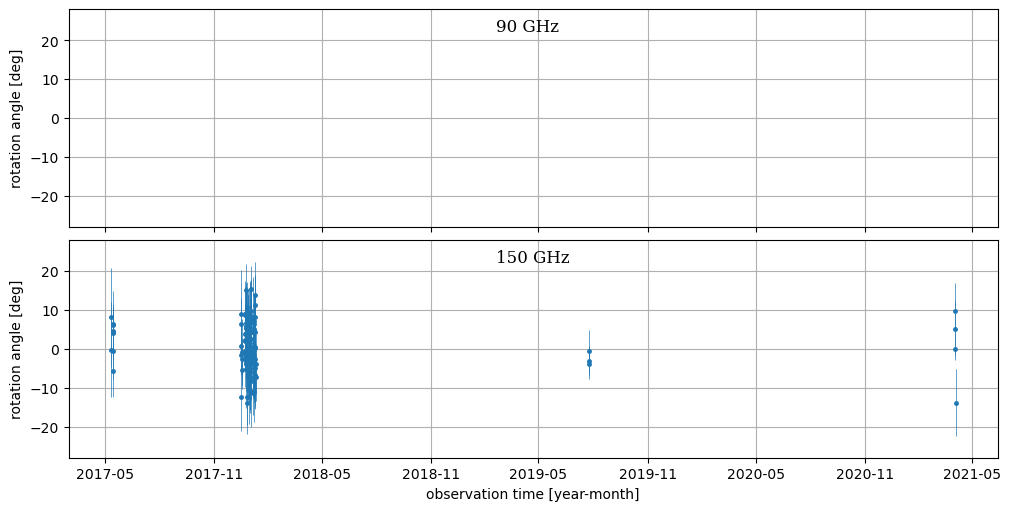

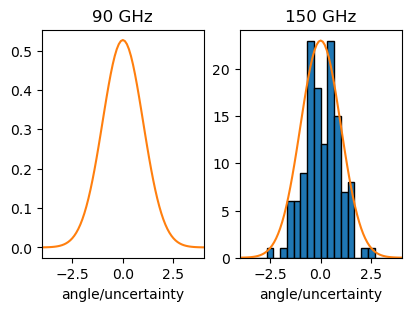

In [10]:
# Plotting timestream with the angle/uncertainty plot
median_timestamps = np.zeros(n_maps)
dates = []
for i in range(n_maps):
    try:
        median_timestamps[i] = spectra_dict[maps[i]]['median_timestamp']
        dates.append(datetime.datetime.fromtimestamp(median_timestamps[i]))
    except KeyError:
        dates.append('0')
#print(median_timestamps[set_pass_all_cuts])
# Converting timestamps to real times
#print(dates[0])
dates = np.array(dates)

# Plotting the timestreams by themselves to see if that resolves crowding issues
fig, axs = plt.subplots(2,1,constrained_layout=True, figsize=(10,5))
for ax in fig.get_axes():
    ax.label_outer()
axs[0].sharex(axs[1])
#axs[0].errorbar(f090_dates, f090_good_angles_deg,
#                  yerr=f090_good_errbars_deg,fmt='.',elinewidth=0.5,markersize=5, color='tab:green')
axs[0].grid()
axs[0].set_ylim(-28.0,28.0)
axs[0].set_ylabel("rotation angle [deg]")
axs[0].text(0.46,0.90,'90 GHz',transform=axs[0].transAxes, fontsize=12, fontname="Serif")
axs[1].errorbar(dates[set_pass_all_cuts], angles_deg[set_pass_all_cuts],
                  yerr=errbars_deg[set_pass_all_cuts],fmt='.',elinewidth=0.5,markersize=5)
axs[1].grid()
axs[1].set_ylim(-28.0,28.0)
axs[1].set_xlabel("observation time [year-month]")
axs[1].set_ylabel("rotation angle [deg]")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs[1].text(0.46,0.90,'150 GHz',transform=axs[1].transAxes, fontsize=12, fontname="Serif")
plt.show()
#plt.savefig("example_timestream_only.png", dpi=300)
plt.close()

# Plotting the histograms by themselves
# Can eventually normalize histograms and Gaussians properly when have full data set 
x = np.arange(-4.0, 4.01, 0.1)
counts, bins = np.histogram(x,bins=24)
fig, axs = plt.subplots(1,2,constrained_layout=True, figsize=(4,3))
#n, _, _ = axs[0].hist(f090_good_angles_deg/f090_good_errbars_deg,bins=bins, edgecolor='black',color='tab:green')
axs[0].set_xlim(-4.0,4.0)
axs[0].set_title("90 GHz")
axs[0].plot(x, np.max(n)*np.exp(-x**2/2),label='Gaussian mean=0 std=1', color='tab:orange')
axs[0].set_xlabel("angle/uncertainty")
n, _, _ = axs[1].hist(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts],bins=bins, edgecolor='black')
axs[1].plot(x, np.max(n)*np.exp(-x**2/2),label='Gaussian mean=0 std=1', color='tab:orange')
axs[1].set_title("150 GHz")
axs[1].set_xlabel("angle/uncertainty")
axs[1].set_xlim(-4.0,4.0)
plt.show()
#plt.savefig("example_angle_error_hist_only.png", dpi=300)
plt.close()

In [11]:
# Checking chi2 for the model fit of estimator-theory for all maps passing cuts 
chi2_good_maps = []
pte_good_maps = []
all_theory_covs = []

test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
ell = spectra_dict[maps[0]]['ell']
bin_size = 400
nu_b = (2*ell+1)*bin_size

for idx in set_pass_all_cuts:
    null = 1.0*estimators[idx] - test_CAMB_EE*np.sin(2*angles_rad[idx])
    theory_cov = 2*test_CAMB_EE**2 * ((np.sin(2*angles_rad[idx])**2/nu_b)+2*np.cos(2*angles_rad[idx])**2*errbars_rad[idx]**2)
    sum_cov = covariances[idx] + theory_cov
    chi2_good_map = np.sum(null**2/(1.0*sum_cov))
    dof_good_map = null.size - 1 # Should be the same each time
    pte_good_map = chi2.sf(chi2_good_map,dof_good_map)
    chi2_good_maps.append(chi2_good_map)
    pte_good_maps.append(pte_good_map)
    all_theory_covs.append(theory_cov)
chi2_good_maps = np.array(chi2_good_maps)
pte_good_maps = np.array(pte_good_maps)
all_theory_covs = np.array(all_theory_covs)

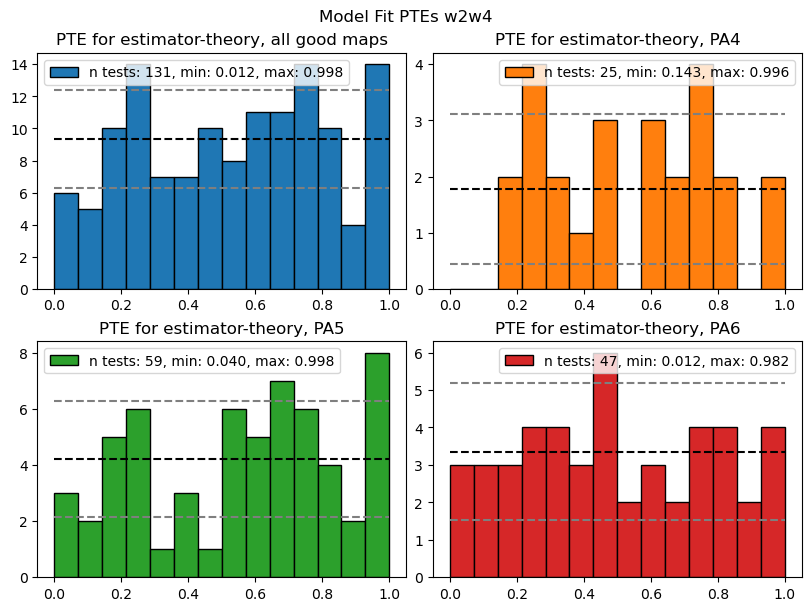

In [12]:
# Making PTE distribution plots 
nbins = 14   # Have been using 10; ACT DR6 papers seem to use 14 for their null tests
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8,6))
fig.suptitle("Model Fit PTEs w2w4")
# All maps
axs[0,0].hist(pte_good_maps,bins=nbins,range=(0.0,1.0), color='tab:blue', edgecolor='black',
              label=f'n tests: {len(pte_good_maps)}, min: {np.min(pte_good_maps):.3f}, max: {np.max(pte_good_maps):.3f}')
per_bin_avg = len(pte_good_maps)/nbins
per_bin_err = np.sqrt(per_bin_avg) 
axs[0,0].hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
axs[0,0].hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,0].hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,0].set_title("PTE for estimator-theory, all good maps")
axs[0,0].legend()
# pa4
idx_pa4 = np.where(map_arrays[set_pass_all_cuts]=='pa4')[0]
axs[0,1].hist(pte_good_maps[idx_pa4], bins=nbins,range=(0.0,1.0), color='tab:orange', edgecolor='black',
             label=f'n tests: {len(pte_good_maps[idx_pa4])}, min: {np.min(pte_good_maps[idx_pa4]):.3f}, max: {np.max(pte_good_maps[idx_pa4]):.3f}')
per_bin_avg = len(pte_good_maps[idx_pa4])/nbins
per_bin_err = np.sqrt(per_bin_avg) 
axs[0,1].hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
axs[0,1].hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,1].hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,1].set_title("PTE for estimator-theory, PA4")
axs[0,1].legend()
# pa5
idx_pa5 = np.where(map_arrays[set_pass_all_cuts]=='pa5')[0]
axs[1,0].hist(pte_good_maps[idx_pa5], bins=nbins,range=(0.0,1.0), color='tab:green', edgecolor='black',
             label=f'n tests: {len(pte_good_maps[idx_pa5])}, min: {np.min(pte_good_maps[idx_pa5]):.3f}, max: {np.max(pte_good_maps[idx_pa5]):.3f}')
per_bin_avg = len(pte_good_maps[idx_pa5])/nbins
per_bin_err = np.sqrt(per_bin_avg) 
axs[1,0].hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
axs[1,0].hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,0].hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,0].set_title("PTE for estimator-theory, PA5")
axs[1,0].legend()
# pa6
idx_pa6 = np.where(map_arrays[set_pass_all_cuts]=='pa6')[0]
axs[1,1].hist(pte_good_maps[idx_pa6], bins=nbins,range=(0.0,1.0), color='tab:red', edgecolor='black',
             label=f'n tests: {len(pte_good_maps[idx_pa6])}, min: {np.min(pte_good_maps[idx_pa6]):.3f}, max: {np.max(pte_good_maps[idx_pa6]):.3f}')
per_bin_avg = len(pte_good_maps[idx_pa6])/nbins
per_bin_err = np.sqrt(per_bin_avg) 
axs[1,1].hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
axs[1,1].hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,1].hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,1].set_title("PTE for estimator-theory, PA6")
axs[1,1].legend()
plt.show()
#plt.savefig('model_fit_pte_w2w4_higherell_largerbins.png')
plt.close()

In [13]:
#######################################################
# Array Differencing Null Test
#######################################################
good_maps = np.array(maps[set_pass_all_cuts])
print("Total number of maps passing cuts: ", len(good_maps))
print("Total number of maps: ", n_maps)
print("Number of PA4 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa4')[0]))
print("Total number of PA4 maps: ", len(np.where(map_arrays=='pa4')[0]))
print("Number of PA5 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa5')[0]))
print("Total number of PA5 maps: ", len(np.where(map_arrays=='pa5')[0]))
print("Number of PA6 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa6')[0]))
print("Total number of PA6 maps: ", len(np.where(map_arrays=='pa6')[0]))
good_timestamps = np.array([m.split('_')[1] for m in good_maps])
unique_good_timestamps = np.unique(good_timestamps)
print("Number of unique timestamps that pass cuts: ", len(unique_good_timestamps))

# Generating a list of all pairs of indices that need to be processed
# Also makes a list of strings showing which arrays each pair goes with for easy counting
all_pairs = []
all_pairs_array_tags = []
for timestamp in unique_good_timestamps:
    indices = set_pass_all_cuts[np.where(good_timestamps==timestamp)[0]] # Getting indices from full list
    if len(indices)>1:
        pairs = [comb for comb in combinations(indices,r=2)]
        for pair in pairs:
            all_pairs.append(pair)
            all_pairs_array_tags.append(map_arrays[pair[0]]+map_arrays[pair[1]])
all_pairs = np.array(all_pairs)
all_pairs_array_tags = np.array(all_pairs_array_tags)
# Getting indices within all_pairs for each set of arrays
pa4pa5_indices = np.where(all_pairs_array_tags=='pa4pa5')[0]
pa4pa6_indices = np.where(all_pairs_array_tags=='pa4pa6')[0]
pa5pa6_indices = np.where(all_pairs_array_tags=='pa5pa6')[0]
print("Total number of array difference pairs: ", len(all_pairs))
print("Total number of array tags: ", len(all_pairs_array_tags))
print("Number of pa4-pa5 pairs: ", pa4pa5_indices.size)
print("Number of pa4-pa6 pairs: ", pa4pa6_indices.size)
print("Number of pa5-pa6 pairs: ", pa5pa6_indices.size)

Total number of maps passing cuts:  131
Total number of maps:  264
Number of PA4 maps passing cuts:  25
Total number of PA4 maps:  88
Number of PA5 maps passing cuts:  59
Total number of PA5 maps:  92
Number of PA6 maps passing cuts:  47
Total number of PA6 maps:  84
Number of unique timestamps that pass cuts:  60
Total number of array difference pairs:  95
Total number of array tags:  95
Number of pa4-pa5 pairs:  25
Number of pa4-pa6 pairs:  24
Number of pa5-pa6 pairs:  46


In [14]:
# Forming chi-squared for array difference null test and calculating PTE for each pair
chi2_all_pairs = []
pte_all_pairs = []
est_diff_all_pairs = []
cov_sum_all_pairs = []

for pair in all_pairs:
    est_diff = estimators[pair[0]] - estimators[pair[1]]
    cov_sum = covariances[pair[0]] + covariances[pair[1]]
    chi2_pair = np.sum(est_diff**2/(1.0*cov_sum)) # Assuming expected value of zero for difference of estimators
    # we eventually decided that dof = n_bins for a true null test, but n_bins-1 for model fitting
    dof_pair = est_diff.size # Should be same each time
    pte_pair = chi2.sf(chi2_pair,dof_pair)
    est_diff_all_pairs.append(est_diff)
    cov_sum_all_pairs.append(cov_sum)
    chi2_all_pairs.append(chi2_pair)
    pte_all_pairs.append(pte_pair)
est_diff_all_pairs = np.array(est_diff_all_pairs)
cov_sum_all_pairs = np.array(cov_sum_all_pairs)
chi2_all_pairs = np.array(chi2_all_pairs)
pte_all_pairs = np.array(pte_all_pairs)

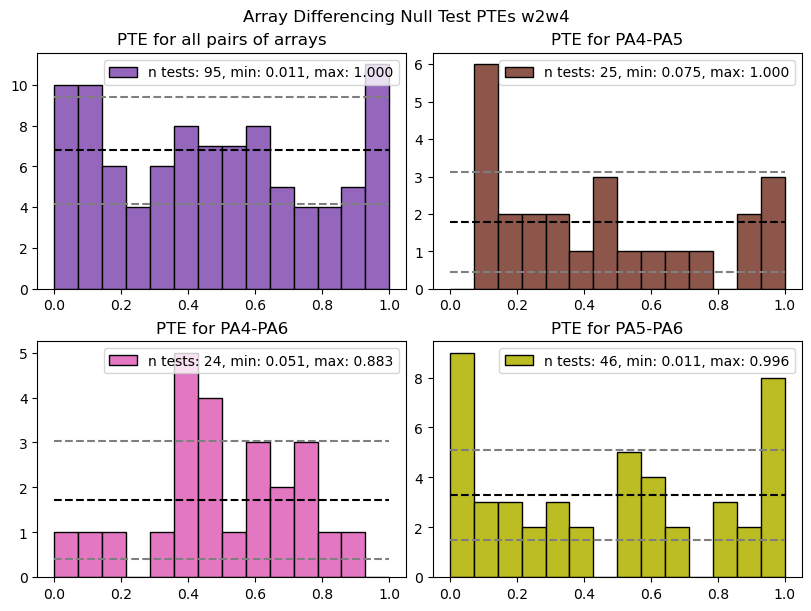

In [15]:
# Making PTE distribution plots 
nbins = 14   # Have been using 10; ACT DR6 papers seem to use 14 for their null tests
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8,6))
fig.suptitle("Array Differencing Null Test PTEs w2w4")
# All pairs
axs[0,0].hist(pte_all_pairs,bins=nbins,range=(0.0,1.0), color='tab:purple', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs)}, min: {np.min(pte_all_pairs):.3f}, max: {np.max(pte_all_pairs):.3f}')
per_bin_avg = len(pte_all_pairs)/nbins
per_bin_err = np.sqrt(per_bin_avg) 
axs[0,0].hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
axs[0,0].hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,0].hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,0].set_title("PTE for all pairs of arrays")
axs[0,0].legend()
# PA4-PA5
axs[0,1].hist(pte_all_pairs[pa4pa5_indices],bins=nbins,range=(0.0,1.0), color='tab:brown', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs[pa4pa5_indices])}, min: {np.min(pte_all_pairs[pa4pa5_indices]):.3f}, max: {np.max(pte_all_pairs[pa4pa5_indices]):.3f}')
per_bin_avg = len(pte_all_pairs[pa4pa5_indices])/nbins
per_bin_err = np.sqrt(per_bin_avg) 
axs[0,1].hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
axs[0,1].hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,1].hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,1].set_title("PTE for PA4-PA5")
axs[0,1].legend()
# PA4-PA6
axs[1,0].hist(pte_all_pairs[pa4pa6_indices],bins=nbins,range=(0.0,1.0), color='tab:pink', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs[pa4pa6_indices])}, min: {np.min(pte_all_pairs[pa4pa6_indices]):.3f}, max: {np.max(pte_all_pairs[pa4pa6_indices]):.3f}')
per_bin_avg = len(pte_all_pairs[pa4pa6_indices])/nbins
per_bin_err = np.sqrt(per_bin_avg) 
axs[1,0].hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
axs[1,0].hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,0].hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,0].set_title("PTE for PA4-PA6")
axs[1,0].legend()
# PA5-PA6
axs[1,1].hist(pte_all_pairs[pa5pa6_indices],bins=nbins,range=(0.0,1.0), color='tab:olive', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs[pa5pa6_indices])}, min: {np.min(pte_all_pairs[pa5pa6_indices]):.3f}, max: {np.max(pte_all_pairs[pa5pa6_indices]):.3f}')
per_bin_avg = len(pte_all_pairs[pa5pa6_indices])/nbins
per_bin_err = np.sqrt(per_bin_avg) 
axs[1,1].hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
axs[1,1].hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,1].hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,1].set_title("PTE for PA5-PA6")
axs[1,1].legend()
plt.show()
#plt.savefig('array_dif_pte_w2w4_higherell_largerbins.png')
plt.close()